In [28]:
# -*- coding: utf-8 -*-

import math
import time
import multiprocessing

import random as rd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import adjusted_rand_score

import numpy as np
import numba as nb
from numba import cuda, float32, int32

In [29]:
m = 1.6
K=10
T = 150
e = 10 ** -10

In [30]:
@cuda.jit
def cuda_calculate_dissimilarity(data, out_diss_mtx):  
    i = cuda.grid(1)
    for k in range(0, len(data)):
        sum=0
        for j in range(0,len(data[k])):
            sum+=(abs(data[i, j]-data[k, j]))**2
        out_diss_mtx[k, i]=math.sqrt(sum)

In [31]:
def random_medoid_vector(D, K):
    return np.array([[rd.randint(0, len(D[j]) - 1) for j in range(len(D))] for _ in range(K)], dtype=np.int16)

In [32]:
def relevance_weight_vector(D, K):
    return np.ones([K + 1, len(D)])

In [33]:
@cuda.jit
def cuda_membership_degree_vector(D, G, L, md_u_i, U):  
    global m, K
    
    p = len(D)
    n = len(D[0])
    k = cuda.grid(1)
    
    for i in range(n):
        accum=0
        for h in range(K):
            up_sum = 0
            down_sum = 0 
            for j in range(p):
                up_sum += L[k, j] * D[j, i, G[k, j]]
            for j in range(p):
                down_sum += L[h, j] * D[j, i, G[h, j]]
            accum += (float(up_sum) / (down_sum + 1e-25)) ** (1. / (m - 1.))

        md_u_i[k]=(accum + 1e-25) ** -1.
        
        U[i, k]=md_u_i[k]
        cuda.syncthreads()

In [34]:
def objective_function(D, G, L, U):  
    global m, K
    n = len(D[0])
    p = len(D)
    accum = 0
    for k in range(K):
        for i in range(n):
            accum += (U[i][k] ** m) * np.array([L[k][j] * D[j][i][G[k][j]] for j in range(p)]).sum()
    return accum


In [35]:
@cuda.jit
def cuda_find_best_medoid(D, U, temp_array, idx, nG):
    global m, K
    
    n = len(D[0])
    p = len(D)
    h = cuda.grid(1)
    for k in range(K):
#         k=1
        for j in range(0, p):
            sum=0
            for i in range(n):
                sum += ((U[i, k] ** m) * (D[j, i, h]))
            temp_array[j, h]=sum
        cuda.syncthreads()
        #find argmin------------------
        for j in range(0, p):
            min=np.inf
            for i in range(temp_array[j].shape[0]):
                if temp_array[j, i]<min:
                    min=temp_array[j, i]
                    idx[j]=i
            nG[k, j]=idx[j]
        #----------------------------------

In [36]:
@cuda.jit
def cuda_calculate_relevance_weights(D, G, U, aux_nL):  
    global m, K
    
    n = len(D[0])
    p = len(D)
    
    k = cuda.grid(1)
    
    for j in range(p):
        prod = 1 
        for h in range(p):
            accum = 0
            for i in range(n):
                accum += ((U[i, k] ** m) * D[h, i, G[k, h]])
            prod *= accum
        up_sum = prod
        down_sum = 0 
        for i in range(n):
            down_sum += ((U[i, k] ** m) * D[j, i, G[k, j]])
        l_k_j = (float(up_sum) ** (1. / p)) / down_sum
        
        aux_nL[k, j]=l_k_j
        cuda.syncthreads()

In [37]:
@cuda.jit
def cuda_find_best_fuzzy_partition(D, G, L, u_i, nU):  
    global m, K
    
    p = len(D)
    n = len(D[0])
    k = cuda.grid(1)
    
    for i in range(n):
        accum=0
        for h in range(K):
            up_sum = 0
            down_sum = 0 
            for j in range(p):
                up_sum += L[k, j] * D[j, i, G[k, j]]
            for j in range(p):
                down_sum += L[h, j] * D[j, i, G[h, j]]
            accum += (float(up_sum) / (down_sum + 1e-25)) ** (1. / (m - 1.))

        u_i[k]=(accum + 1e-25) ** -1.
        
        nU[i, k]=u_i[k]
        cuda.syncthreads()



In [38]:
# datasets 
a1 = np.loadtxt("read_data/mfeat-fou")
a2 = np.loadtxt("read_data/mfeat-fac")
a3 = np.loadtxt("read_data/mfeat-kar")

d1 = np.array(a1, dtype=np.float32)
d2 = np.array(a2, dtype=np.float32)
d3 = np.array(a3, dtype=np.float32)

scaler = MinMaxScaler(feature_range=(0, 1))
d1 = scaler.fit_transform(d1)
d2 = scaler.fit_transform(d2)
d3 = scaler.fit_transform(d3)

X1, Y1=d1.shape
X2, Y2=d2.shape
X3, Y3=d3.shape


In [39]:
out_diss_mtx1=np.empty(shape=(X1, X1), dtype=np.float32)
out_diss_mtx2=np.empty(shape=(X2, X2), dtype=np.float32)
out_diss_mtx3=np.empty(shape=(X3, X3), dtype=np.float32)

In [40]:
s1 = time.time()
cuda.current_context().deallocations.clear()
with cuda.defer_cleanup():
    threadsperblock = 1024
    blockspergrid = (X1 + (threadsperblock - 1)) // threadsperblock
    cuda_calculate_dissimilarity[blockspergrid, threadsperblock](d1, out_diss_mtx1)
print("Calculate Mtx1: {}".format(time.time() - s1))

s1 = time.time()
cuda.current_context().deallocations.clear()
with cuda.defer_cleanup():
    threadsperblock = 1024
    blockspergrid = (X2 + (threadsperblock - 1)) // threadsperblock
    cuda_calculate_dissimilarity[blockspergrid, threadsperblock](d2, out_diss_mtx2)
print("Calculate Mtx2: {}".format(time.time() - s1))

s1 = time.time()
cuda.current_context().deallocations.clear()
with cuda.defer_cleanup():
    threadsperblock = 1024
    blockspergrid = (X3 + (threadsperblock - 1)) // threadsperblock
    cuda_calculate_dissimilarity[blockspergrid, threadsperblock](d3, out_diss_mtx3)
print("Calculate Mtx3: {}".format(time.time() - s1))


Calculate Mtx1: 0.3670084476470947
Calculate Mtx2: 0.3057377338409424
Calculate Mtx3: 0.06549644470214844


In [41]:
import time, sys
from IPython.display import clear_output
def update_progress(progress, u_t, exe_id):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    
    text1 = "Execution index: {0} {1:d}".format(("" * block + "" * (bar_length - block*100)), (exe_id))
    print(text1)
    
    text2 = "Objective function value: {0} {1:.16f}".format(("" * block + "" * (bar_length - block*100)), (u_t))
    print(text2)
    
    text3 = "Iteration progress: [{0}] {1:.1f}%".format(("#" * block + "-" * (bar_length - block)), (progress * 100))
    print(text3)
    
    
    

In [42]:
def training(exe_id):
    global K, m, T, e
    
    D = np.array([out_diss_mtx1, out_diss_mtx2, out_diss_mtx3])
    X,Y,Z=D.shape
    
    #params membership degree
    md_u_i=np.empty(shape=(K), dtype=np.float32)
    U=np.empty(shape=(Y, K), dtype=np.float32)
    
    #params cuda_find_best_medoid
    temp_array=np.empty(shape=(X*K, len(D[0])), dtype=np.float32)
    # print(temp_array.shape)
    idx=np.zeros(shape=(K), dtype=np.float32)
    nG=np.empty(shape=(K, X), dtype=np.float32)
    
    #params cuda_calculate_relevance_weights
    aux_nL=np.empty(shape=(K, X), dtype=np.float64)
    
    #params cuda_find_best_fuzzy_partition
    u_i=np.empty(shape=(K), dtype=np.float32)
    nU=np.empty(shape=(Y, K), dtype=np.float32)
    
    G = random_medoid_vector(D, K)
    L = relevance_weight_vector(D, K)
    
   #--------------------------------------------
    #s1 = time.time()
    cuda.current_context().deallocations.clear()
    with cuda.defer_cleanup():
        threadsperblock = 1024
        blockspergrid = (Y + (threadsperblock - 1)) // threadsperblock
        cuda_membership_degree_vector[blockspergrid, threadsperblock](D, G, L, md_u_i, U)
    #print("Membership degree time: {}".format(time.time() - s1))
    #--------------------------------------------
    
    u_t = objective_function(D, G, L, U)
    u_t_m1 = np.inf 
    
    best_j, best_cfg = np.inf, None
    for t in range(T):
        
        #--------------------------------------------
        #s1 = time.time()           
        cuda.current_context().deallocations.clear()
        with cuda.defer_cleanup():
            threadsperblock = 1024
            blockspergrid = (Y + (threadsperblock - 1)) // threadsperblock
            cuda_find_best_medoid[blockspergrid, threadsperblock](D, U, temp_array, idx, nG)
        nG=np.array(nG, dtype=np.int16)
        #print("cuda_find_best_medoid time: {}".format(time.time() - s1))
        #--------------------------------------------
        
        #--------------------------------------------
        #s1 = time.time()
        cuda.current_context().deallocations.clear()
        with cuda.defer_cleanup():
            threadsperblock = 1024
            blockspergrid = (Y + (threadsperblock - 1)) // threadsperblock
            cuda_calculate_relevance_weights[blockspergrid, threadsperblock](D, nG, U, aux_nL)
        nL=aux_nL
        #print("cuda_calculate_relevance_weights time: {}".format(time.time() - s1))
        #--------------------------------------------
        
        #--------------------------------------------
        #s1 = time.time()
        cuda.current_context().deallocations.clear()
        with cuda.defer_cleanup():
            threadsperblock = 1024
            blockspergrid = (Y + (threadsperblock - 1)) // threadsperblock
            cuda_find_best_fuzzy_partition[blockspergrid, threadsperblock](D, nG, nL, u_i, nU)
        #print("cuda_find_best_fuzzy_partition time: {}".format(time.time() - s1))
        #--------------------------------------------
        
        u_t_m1 = u_t
        #s1 = time.time()
        u_t = objective_function(D, nG, nL, nU)
        #print("Objective function time: {}".format(time.time() - s1))

        udif = u_t - u_t_m1
        G = nG
        L = nL
        U = nU
        
        update_progress((t / T), u_t, exe_id)
        
        #-----------------------------------------------------
        if u_t < best_j:
            params = (G, L, U)
            best_j, best_cfg = u_t, params
            
        if (abs(udif)<e):
            break
            
    update_progress(1, best_j, exe_id)
    return best_j, params

In [43]:
print ("Start training ...")
global K

best_j_exec, best_cfg_exec = np.inf, None
# Execution
for exe_id in range(1):  
    best_j, params = training(exe_id)

    print("The best value of the objective function in this iteration is: {}".format(best_j))
        
    if best_j < best_j_exec:
        best_j_exec, best_cfg_exec = best_j, params
    
print("The best value of the objective function in all executions is: {}".format(best_j_exec))


Execution index:  0
Objective function value:  3164.0443912128394004
Iteration progress: [##################################################] 100.0%
The best value of the objective function in this iteration is: 3164.0443912128394
The best value of the objective function in all executions is: 3164.0443912128394


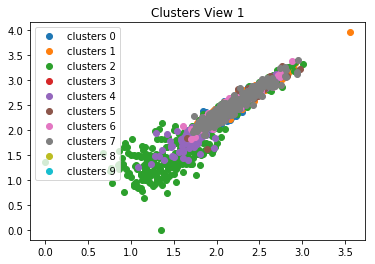

In [44]:
G, L, U=best_cfg_exec
#print(G)
U = U.T
# Show cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Clusters View 1')
for j in range(K):
    #print(U.argmax(axis=0))
    ax2.plot(out_diss_mtx1[0, U.argmax(axis=0) == j],
             out_diss_mtx1[1, U.argmax(axis=0) == j], 'o',
             label='clusters ' + str(j))
ax2.legend()
plt.show()

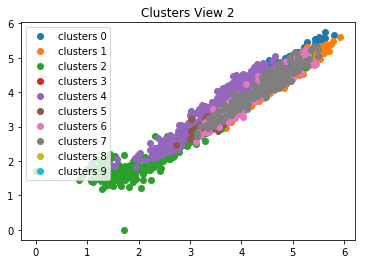

In [45]:
G, L, U=best_cfg_exec
#print(G)
U = U.T
# Show cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Clusters View 2')
for j in range(K):
    #print(U.argmax(axis=0))
    ax2.plot(out_diss_mtx2[0, U.argmax(axis=0) == j],
             out_diss_mtx2[1, U.argmax(axis=0) == j], 'o',
             label='clusters ' + str(j))
ax2.legend()
plt.show()


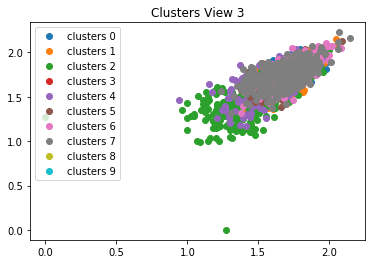

In [46]:
G, L, U=best_cfg_exec
#print(G)
U = U.T
# Show cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Clusters View 3')
for j in range(K):
    #print(U.argmax(axis=0))
    ax2.plot(out_diss_mtx3[0, U.argmax(axis=0) == j],
             out_diss_mtx3[1, U.argmax(axis=0) == j], 'o',
             label='clusters ' + str(j))
ax2.legend()
plt.show()

[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]
[1 1 1 ... 7 0 2]


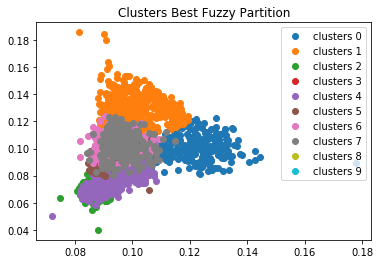

In [47]:
fig2, ax2 = plt.subplots()
ax2.set_title('Clusters Best Fuzzy Partition')
for j in range(K):

    print(U.argmin(axis=0))
    ax2.plot(U[0, U.argmax(axis=0) == j],
             U[1, U.argmax(axis=0) == j], 'o',
             label='clusters ' + str(j))
ax2.legend()
plt.show()

In [48]:
def crisp_partition(U):
    return U.argmin(axis=0)

In [49]:
u_crisp=crisp_partition(U)
u_crisp.shape

(2000,)

In [50]:
import collections
print(collections.Counter(U.argmax(axis=0)))
print(collections.Counter(u_crisp))


Counter({1: 459, 2: 402, 7: 322, 4: 321, 0: 278, 6: 146, 5: 72})
Counter({1: 756, 2: 398, 4: 321, 0: 245, 6: 145, 7: 123, 5: 12})


In [51]:
samples=200
labels=10
y=np.array([[l for s in range(samples)] for l in range(labels)]).flatten()
print(y)

[0 0 0 ... 9 9 9]


In [52]:
rand_crisp = adjusted_rand_score(u_crisp,y)
print("Crisp partition corrected rand index: {:.16f}".format(rand_crisp))


Crisp partition corrected rand index: 0.1706653047417132


In [53]:
print(u_crisp)

[1 1 1 ... 7 0 2]


In [54]:
np.savetxt("aux_data/u_crisp.txt", u_crisp)